1. Data Collection

1.1 Import Library

In [1]:
#import library
import sys
import os
import numpy as np # type: ignore
import pandas as pd
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt
sys.path.append('../scripts')
import Preprocessing as dp
import quantitative_analysis as qan
import EDA as eda
import sentiment_analysis as san

1.2 Load dataset

In [2]:
# Load news and stock data
news_data = dp.load_data("../data/raw_analyst_ratings.csv")
stock_data = dp.load_data("../data/META_historical_data.csv")

In [3]:
news_data.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [4]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,2012-12-12,28.000000,28.139999,27.370001,27.580000,27.523441,46704200,0.0,0.0
1,2012-12-13,27.590000,28.750000,27.430000,28.240000,28.182087,81051600,0.0,0.0
2,2012-12-14,28.180000,28.330000,26.760000,26.809999,26.755020,91631600,0.0,0.0
3,2012-12-17,26.770000,27.000000,26.320000,26.750000,26.695143,57742500,0.0,0.0
4,2012-12-18,26.959999,27.910000,26.900000,27.709999,27.653173,60512900,0.0,0.0


Date Conversion

In [5]:
# Convert 'date' column in news data and 'Date' column in stock data to datetime
news_data = dp.convert_date(news_data, column_name='date')
stock_data = dp.convert_date(stock_data, column_name='Date')

In [6]:
# Filter stock data to match the date range of news data
start_date = news_data['date'].min()
end_date = news_data['date'].max()
stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]


In [7]:
# Sentiment analysis
news_data['sentiment_score'] = news_data['headline'].apply(san.get_sentiment_score)
news_data['sentiment'] = news_data['sentiment_score'].apply(san.categorize_sentiment)


In [8]:
# Calculate daily returns for stock
stock_data['daily_return'] = stock_data['Close'].pct_change()

# Rename columns to avoid conflicts
news_data.rename(columns={'date': 'Date'}, inplace=True)

In [9]:
# Merge news data with stock data on Date
combined_data = pd.merge(stock_data, news_data, on='Date', how='left')


In [10]:
# Aggregate sentiment scores by date
daily_sentiment = combined_data.groupby('Date')['sentiment_score'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_score': 'average_sentiment_score'}, inplace=True)


In [11]:
# Merge aggregated sentiment with combined data
final_data = pd.merge(combined_data, daily_sentiment, on='Date', how='left')
final_data = final_data[['Date', 'average_sentiment_score', 'Close', 'daily_return']]
final_data.head()

,Date,average_sentiment_score,Close,daily_return
0,2012-12-12,0.037132,27.58,NaN
1,2012-12-12,0.037132,27.58,NaN
2,2012-12-12,0.037132,27.58,NaN
3,2012-12-12,0.037132,27.58,NaN
4,2012-12-12,0.037132,27.58,NaN


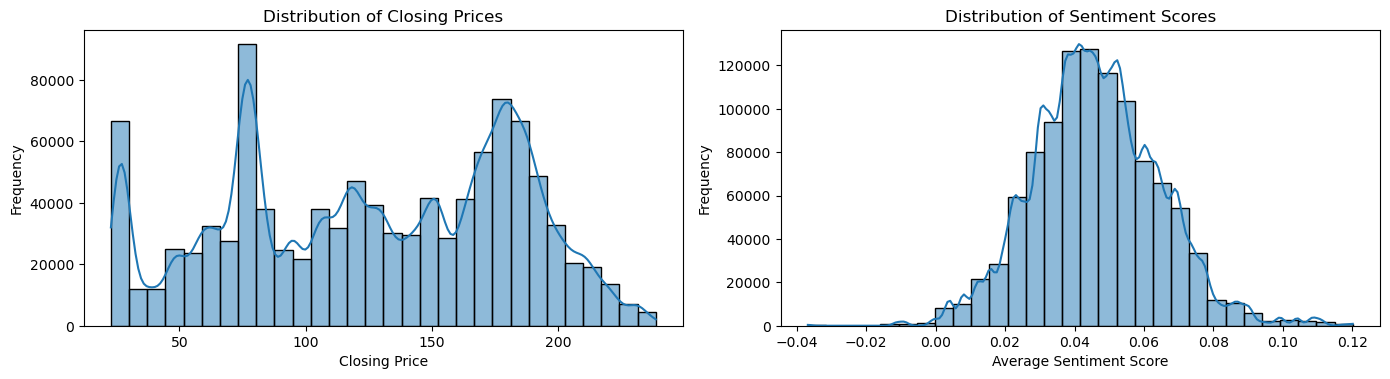

In [12]:
# Data visualization
eda.plot_distributions(final_data)

In [13]:
# Calculate correlation between sentiment and daily return
correlation_return = final_data[['average_sentiment_score', 'daily_return']].corr().iloc[0, 1]
print(f"Correlation between sentiment and daily return: {correlation_return}")


Correlation between sentiment and daily return: 0.12018639413041395


In [14]:
# Calculate correlation between sentiment and closing price
correlation_close = final_data[['average_sentiment_score', 'Close']].corr().iloc[0, 1]
print(f"Correlation between sentiment and closing price: {correlation_close}")


Correlation between sentiment and closing price: -0.15376425085047554


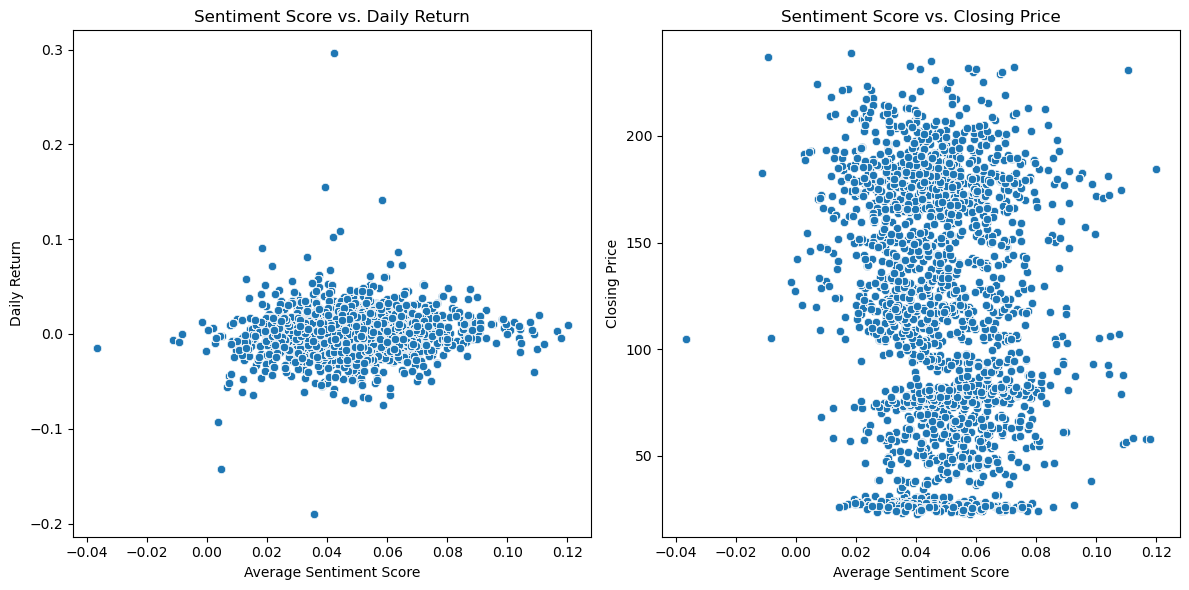

In [15]:
# Scatter plot for sentiment score vs. daily return
eda.plot_scatter(final_data)

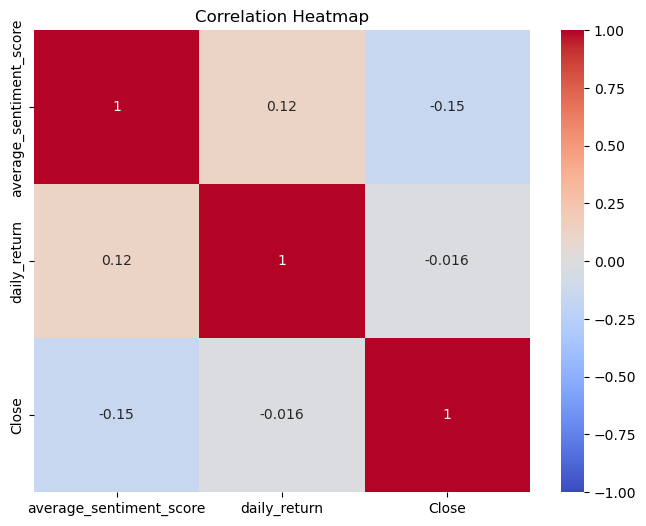

In [16]:
# Compute correlation matrix
eda.plot_heatmap(final_data)